In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from tqdm import tqdm #progress bar
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.utils import save_image

from IPython.display import HTML

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/Dataset/Celeb/celebData/train'

In [ ]:
# Defining the hyper-parameters 

# Batch Size for the dataset
BATCH_SIZE = 128

# setting image sizes for our dataset 
# normally 178*218 however we will reduce it to 64 for the sake of trainning
IMG_SIZE = 64

# setting the number of workers
WORKERS = 2

# number of channels for images in our case is 3 colors (RGB)
CHANNELS_NUMBER = 3

# setting the size of the feature maps for generator
gen_feature = 64

# setting the size of the feature maps for discriminator
dis_feature = 64

# setting the number of epochs
EPOCH_NUMBER = 10


# setting the learning rate 
lr = 0.0002


In [ ]:
class FacesDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        #self.target_transform = target_transform
        self.label = 1  #because there are only good images in this dataset

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, os.listdir(self.img_dir)[idx])
        image = read_image(img_path)
            
        if self.transform:
            image = self.transform(image)
        return image, self.label

In [ ]:
transform=transforms.Compose([
                               transforms.Resize(IMG_SIZE),
                               transforms.CenterCrop(IMG_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

In [ ]:
train_dataset = dset.ImageFolder(root=train_dir,
                           transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
    shuffle=True, pin_memory=True,drop_last=True)

In [ ]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

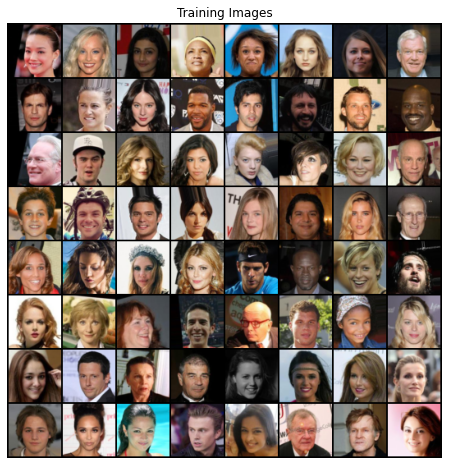

In [ ]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=4, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # 512 x 4 x 4 upsampled data

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # 256 x 8 x 8

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 128 x 16 x 16

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 64 x 32 x 32

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # 3 x 64 x 64
            )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # 512 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
            # 1 x 1 x 1
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create an instance of generator 
gen_net = Generator().to(device)

if (device.type == 'cuda'):
    gen_net = nn.DataParallel(gen_net, list(range(1)))

print(gen_net)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

In [ ]:
# Create the Discriminator
dis_net = Discriminator().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda'):
    dis_net = nn.DataParallel(dis_net, list(range(1)))

# Print the model
print(dis_net)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2, inplace=True)
      (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.2, 

In [ ]:
# define loss function
loss_fn = nn.BCELoss()

beta1 = 0.5
# Setup Adam optimizers for both G and D
dis_optimizer = optim.Adam(dis_net.parameters(), lr=lr, betas=(beta1, 0.999))
gen_optimizer = optim.Adam(gen_net.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
fake_list = []
gen_losses = []
dis_losses =[]
# Train the GAN
for epoch in tqdm(range(EPOCH_NUMBER)):
    for i, (X_batch, _) in enumerate(train_loader):
        # Move the images and labels to the device
        X_batch = X_batch.to(device)

        # Train the discriminator on real images
        dis_optimizer.zero_grad()
        # check the torch img dimensions and set labels accordingly
        real_labels = torch.ones(128, 1).to(device)
        fake_labels = torch.zeros(128, 1).to(device)

        real_outputs = dis_net(X_batch)
        real_loss = loss_fn(real_outputs, real_labels)
        real_loss.backward()
        dis_optimizer.step()

        # Train the discriminator on fake images
        noise = torch.randn(BATCH_SIZE, 100, 1, 1, device=device)
        fake_images = gen_net(noise)
        fake_outputs = dis_net(fake_images.detach())
        fake_loss = loss_fn(fake_outputs, fake_labels)
        fake_loss.backward()
        dis_optimizer.step()

        # save the loss for discriminator
        dis_losses.append((real_loss.item() + fake_loss.item()))

        # Train the generator
        gen_optimizer.zero_grad()
        noise = torch.randn(BATCH_SIZE, 100, 1, 1, device=device)
        fake_images = gen_net(noise)
        fake_outputs = dis_net(fake_images)
        gen_loss = loss_fn(fake_outputs, real_labels)
        gen_losses.append(gen_loss)
        gen_loss.backward()
        gen_optimizer.step()

    save_image(fake_images, "/content/drive/MyDrive/Dataset/Fake_Images_3/{0:0=6d}.png" .format(epoch+1), nrow=5, normalize=True)
    x_fake = fake_images.detach().cpu().numpy()

    for k in range(EPOCH_NUMBER):
        plt.subplot(2, 5, k+1)
        plt.imshow(x_fake[k].reshape(64,64,3))
       #  * 255).astype(np.uint8))
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.show()
    
    print("Epoch: %d, D Loss: %.4f, G Loss: %.4f" % (epoch+1, real_loss.item() + fake_loss.item(), gen_loss.item()))

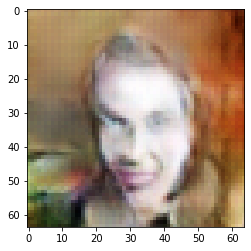

In [ ]:
plt.imshow(np.transpose(vutils.make_grid(fake_images[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
ge = torch.tensor(gen_losses).long()
de = torch.tensor(dis_losses).long()

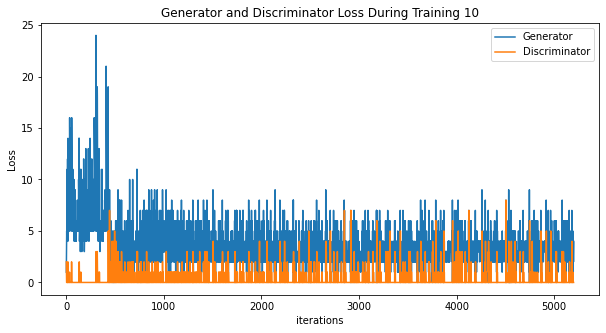

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training "+ str(EPOCH_NUMBER))
plt.plot(ge,label="Generator")
plt.plot(de,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Losses During Training with '+str(EPOCH_NUMBER)+'epochs diff model')
plt.show()

In [ ]:
torch.save(dis_net.state_dict(), "/content/drive/MyDrive/Colab Notebooks/NN PROJECT/Weights_3/disc10epoch.pt")
torch.save(gen_net.state_dict(), "/content/drive/MyDrive/Colab Notebooks/NN PROJECT/Weights_3/gen10epoch.pt")

In [ ]:
torch.save(gen_net, '/content/drive/MyDrive/Colab Notebooks/NN PROJECT/models_3/base_gen_10e.pt')
torch.save(dis_net, '/content/drive/MyDrive/Colab Notebooks/NN PROJECT/models_3/base_dis_10e.pt')